## Анализ A/B-теста

Структура проекта:
- [Загрузка данных и ознакомление с ними](#1)
- [Предобработка данных](#2)
- [Анализ данных](#3)
- [Выводы](#4)

### <a name="1"> Загрузка данных и ознакомление с ними </a>

Загрузим необходимые библиотеки для работы с таблицами, визуализации и проверки гипотез:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

Загрузим данные:

In [2]:
groups = pd.read_csv('/Users/polzovatel/Desktop/groups.csv', sep=';')
checks = pd.read_csv('/Users/polzovatel/Desktop/checks.csv', sep=';')
active_studs = pd.read_csv('/Users/polzovatel/Desktop/active_studs.csv', sep=';')

Посмотрим на таблицу groups:

In [3]:
groups.head()

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


In [4]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
groups.duplicated().sum()

0

В таблице 74 576 строк, дублей нет. Это значит, что в тестировании приняли участие 74 576 учеников. 

In [6]:
groups['grp'].value_counts()

B    59883
A    14693
Name: grp, dtype: int64

Группы не сбалансированы: группа B примерно в 4 раза больше группы A.

Посмотрим на таблицу active_studs:

In [7]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
active_studs.shape[0]

8341

In [9]:
active_studs.duplicated().sum()

0

8341 ученик были активны в период проведения теста.

Посмотрим на таблицу checks:

In [10]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [11]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [12]:
checks['student_id'].nunique()

541

In [13]:
checks.duplicated().sum()

0

541 ученик совершил оплату в период проведения теста.

### <a name="2"> Предобработка данных </a>

В ходе ознакомления с данными не было выявлено пропусков и дублей. Проверим наличие выбросов:

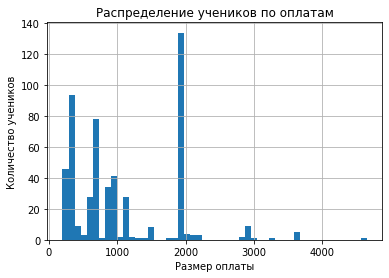

In [14]:
checks['rev'].hist(bins=50)
plt.title("Распределение учеников по оплатам") 
plt.xlabel("Размер оплаты")
plt.ylabel("Количество учеников") 
plt.show()

Распределение не похоже на нормальное. Видимо это связано с тем, что ученики оплачивают программы с фиксированными ценами. Посмотрим топ-3 оплат:

In [15]:
checks['rev'].value_counts().head(3)

1900.0    97
290.0     94
690.0     78
Name: rev, dtype: int64

Программы, которые в основном оплачивают, стоят 1900, 290 и 690.

Посмотрим 95 и 99 процентили по оплатам, а также максимальное значение:

In [16]:
np.percentile(checks['rev'], [95, 99]), checks['rev'].max()

(array([1980., 3500.]), 4650.0)

Всё же максимальное значение находится в том же порядке, что и 95 и 99 процентили, поэтому не будем его считать за выброс.

Напоследок объединим все таблицы по id учеников. Так будет удобнее дальше проводить анализ теста:

In [17]:
df = active_studs.merge(groups, left_on='student_id', right_on='id', how='right')\
.merge(checks, left_on='id', right_on='student_id', how='left')

Посмотрим на таблицу:

In [18]:
df.head()

,student_id_x,id,grp,student_id_y,rev
0,NaN,1206794,B,NaN,NaN
1,NaN,331024,B,NaN,NaN
2,NaN,1733498,A,NaN,NaN
3,NaN,161574,B,NaN,NaN
4,NaN,168443,B,NaN,NaN


Проверим, что никакие данные не потерялись:

In [19]:
df['id'].count(), df['student_id_x'].count(), df['rev'].count()

(74576, 8341, 541)

Данные не потерялись: остались 74 576 учеников, 8341 из них активных и 541 оплативших.

### <a name="3"> Анализ данных </a>

Сгруппируем клиентов по группам и посчитаем:
- размер средней оплаты (средний чек);
- суммарную выручку;
- количество оплативших учеников;
- количество заходивших учиться учеников;
- суммарное количество учеников;
- конверсию "оплатившие ученики / всего учеников";
- конверсию "оплатившие ученики / учившиеся ученики".

In [20]:
df_grouped = df.groupby('grp').agg({'rev': ['mean', 'sum', 'count'], 'student_id_x': 'count', 'id': 'count'})\
.reset_index()
df_grouped.columns = df_grouped.columns.droplevel(0)
df_grouped.columns = ['group', 'mean_check', 'sum_rev', 'paid_clients', 'studied_clients', 'total_clients']
df_grouped['cr_total'] = df_grouped['paid_clients'] / df_grouped['total_clients']
df_grouped['cr_studied'] = df_grouped['paid_clients'] / df_grouped['studied_clients']
df_grouped

,group,mean_check,sum_rev,paid_clients,studied_clients,total_clients,cr_total,cr_studied
0,A,860.710280,92096.0000,107,1538,14693,0.007282,0.069571
1,B,1108.824893,481230.0036,434,6803,59883,0.007247,0.063795


Видна разница в среднем чеке - у группы B она выше. Проверим, есть ли статистически значимая разница между средними чеками. Сформулируем нулевую и альтернативную гипотезы:

H0: новая механика оплаты услуг на сайте не увеличивает средний чек.

H1: новая механика оплаты услуг на сайте увеличивает средний чек.

Для проверки гипотезы выберем статистический критерий. Так как:
- данные количественные (оплаты);
- распределение не нормальное;
- сравниваем 2 выборки;
- которые независимы,
то будем использовать непараметрический критерий Манна-Уитни.

Критическим значеним альфа возьмём 0,05.

Составим выборки оплат в группах и проверим, что не потеряли ни одну оплату:

In [21]:
sample_A = df.query('grp == "A"')['rev'].dropna()
sample_B = df.query('grp == "B"')['rev'].dropna()
len(sample_A), len(sample_B)

(107, 434)

Все оплаты есть. Теперь воспользуемся функцией mannwhitneyu и рассчитаем p-value:

In [22]:
results = st.mannwhitneyu(sample_B, sample_A, alternative='two-sided')
results.pvalue

0.00019316054996380152

Вероятность того, что выборки с оплатами относятся к одной генеральной совокупности меньше 0,05. В связи с этим у нас есть основания отвергнуть нулевую гипотезу и принять альтернативную - новая механика оплаты услуг на сайте увеличивает средний чек.

Конверсии "оплатившие ученики / всего учеников" практически идентичны. Скорее всего статистически значимой разницы в них нет. Но на всякий случай проверим. Сформулируем нулевую и альтернативную гипотезы:

H0: новая механика оплаты услуг на сайте не увеличивает конверсию "оплатившие ученики / всего учеников".

H1: новая механика оплаты услуг на сайте увеличивает конверсию "оплатившие ученики / всего учеников".

Для проверки гипотез о равенстве конверсий применяют z-критерий.

Критическим значеним альфа возьмём 0,05.

In [23]:
count = [df_grouped.iloc[0, 3], df_grouped.iloc[1, 3]] # количество оплативших учеников
nobs = [df_grouped.iloc[0, 5], df_grouped.iloc[1, 5]] # суммарное количество учеников
p_value = proportions_ztest(count, nobs)[1]
p_value

0.9643566949670365

Вероятность того, что выборки относятся к одной генеральной совокупности с точки зрения конверсии "оплатившие ученики / всего учеников" значительно больше 0,05. В связи с этим у нас нет оснований отвергнуть нулевую гипотезу. Это значит, что новая механика оплаты услуг на сайте не увеличивает конверсию "оплатившие ученики / всего учеников".

### <a name="4"> Выводы </a>

По итогам теста можно сделать два вывода:
- так как новая механика оплаты услуг на сайте увеличивает средний чек и не ухудшает конверсию "оплатившие ученики / всего учеников", то её можно запускать на всех учеников;
- в будущем при проведении тестирования группы A и B следует делать сбалансированными. Это минимизирует вероятность ошибочных выводов при проведении анализа.